In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

0         1         2         3         4         5         6   \
0      2.964  2.322959  1.544607  0.778310  1.962012  2.677445  0.237877   
1      2.584  2.371797  1.544607  0.778310  1.962012  2.733737  0.192929   
2      3.071  2.415961  1.319880  0.665072  1.676555  2.784640  0.382869   
3      2.694  2.302538  1.319880  0.665072  1.676555  2.653908  0.442052   
4      2.569  2.363063  0.913154  0.460128  1.159919  2.723669  0.192242   
...      ...       ...       ...       ...       ...       ...       ...   
35131  1.664  2.244719  1.455982  0.733653  1.849437  2.587266  0.205654   
35132  1.659  2.136340  1.201186  0.605264  1.525786  2.462348  0.201219   
35133  1.664  2.192805  1.201186  0.605264  1.525786  2.527430  0.228585   
35134  1.697  1.446083  0.259545  0.130782  0.329682  1.666757  0.189302   
35135  1.673  1.174827  0.259545  0.130782  0.329682  1.354107  0.208899   

             7         8         9   ...        41        42        43  \
0      0.689194  0.358525  0.814643  ...  0.898895  0.203825  0.221624   
1      0.558967  0.358525  0.660712  ...  0.917793  0.165311  0.179747   
2      1.109272  0.377198  1.311186  ...  0.934883  0.328060  0.356708   
3      1.280743  0.377198  1.513868  ...  0.890992  0.378772  0.411848   
4      0.556976  0.668500  0.658358  ...  0.914413  0.164722  0.179106   
...         ...       ...       ...  ...       ...       ...       ...   
35131  0.595835  0.171793  0.704291  ...  0.868619  0.176214  0.191602   
35132  0.582985  0.067223  0.689101  ...  0.826680  0.172414  0.187470   
35133  0.662271  0.067223  0.782819  ...  0.848530  0.195862  0.212966   
35134  0.548459  0.070958  0.648292  ...  0.559578  0.162203  0.176368   
35135  0.605235  0.070958  0.715402  ...  0.454612  0.178994  0.194625   

             44        45        46        47        48        49        50  
0      0.319531  0.830996  0.924987  0.219128  0.274880  0.990488  0.779475  
1      0.319531  0.848467  0.944434  0.177722  0.222940  1.011313  0.795863  
2      0.336174  0.864266  0.962019  0.352691  0.442426  1.030144  0.810682  
3      0.336174  0.823691  0.916855  0.407209  0.510816  0.981781  0.772623  
4      0.595793  0.845343  0.940956  0.177089  0.222146  1.007588  0.792932  
...         ...       ...       ...       ...       ...       ...       ...  
35131  0.153109  0.803007  0.893832  0.189444  0.237645  0.957128  0.753222  
35132  0.059912  0.764237  0.850676  0.185359  0.232519  0.910916  0.716855  
35133  0.059912  0.784436  0.873160  0.210568  0.264142  0.934992  0.735802  
35134  0.063241  0.517310  0.575820  0.174381  0.218749  0.616596  0.485237  
35135  0.063241  0.420273  0.467808  0.192433  0.241394  0.500935  0.394216  

[35136 rows x 51 columns]

## Auxiliary Functions

In [3]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    #wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    mape = mae / actuals.mean()  
    r2 = r2_score(actuals, preds)

    # print performance metrics
    #print('MSE: %.4f' % mse)
    #print('RMSE: %.4f' % rmse)
    #print('MAE: %.4f' % mae)
    #print('MAPE: %.4f' % (mape * 100))
    #print('R2: %.4f' % r2)
    return mse, rmse, mae, mape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return model, preds

In [4]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)*100/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    
def predict_show_results(X_train, X_test, y_train, y_test):
    
    model_list, preds_list, metrics_list = [], [], []
    
    for h in range(0, number_of_houses):
        #print("\tHouse {}".format(h))
        model, preds = build_model(LinearRegression(), X_train[h], y_train[h], X_test[h])
        mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test[h].values.reshape(-1))
        #plot_results(preds, y_test[h].values.reshape(-1), "House {}".format(h))
        model_list.append(model)
        preds_list.append(preds)
        metrics_list.append((mse,rmse,mae,mape,r2))
    return model_list, preds_list, metrics_list

def split_train_test(X, y):
    X_train, X_test = [],[]
    for h in range(0,number_of_houses):
        n_train_samples = int(len(X[h]) * 0.8)
        X_train.append(X[h][:n_train_samples])
        X_test.append(X[h][n_train_samples:])
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def last_energy_points(df, number_timesteps):
    
    X = []
    y = df.copy()
    y = y.iloc[number_timesteps:]

    for h in range(0,number_of_houses):
        X_house = pd.DataFrame()
        for i in range(1, (number_timesteps+1)):
            X_house[f'Energy_{i*15}'] = df[h].shift(i)
        X_house = X_house.dropna().reset_index(drop=True)
        X.append(X_house)
    return X, y

def prepare_polynomial(X, y, deg):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_train, X_test, y_train, y_test = [],[],[],[]
    for h in range(0, number_of_houses):
        poly_features = poly.fit_transform(X[h])
        X_tr, X_te, y_tr, y_te = train_test_split(poly_features, y[h], train_size=0.8, random_state=42)
        X_train.append(X_tr)
        X_test.append(X_te)
        y_train.append(y_tr)
        y_test.append(y_te)
    return X_train, X_test, y_train, y_test

## Last Energy point (15 minutes)

In [5]:
X_15, y_15 = last_energy_points(df, 1)
len(X_15), len(y_15)

(51, 35135)

### Split into train and test

In [6]:
X_15_train, X_15_test, y_15_train, y_15_test = split_train_test(X_15, y_15)
print(X_15_train[0].shape, X_15_test[0].shape, y_15_train.shape, y_15_test.shape)

(28108, 1) (7027, 1) (28108, 51) (7027, 51)


## Last 2 energy points (30 minutes)

In [7]:
X_30, y_30 = last_energy_points(df, 2)
len(X_30), len(y_30)

(51, 35134)

### Split into train and test

In [8]:
X_30_train, X_30_test, y_30_train, y_30_test = split_train_test(X_30, y_30)
print(X_30_train[0].shape, X_30_test[0].shape, y_30_train.shape, y_30_test.shape)

(28107, 2) (7027, 2) (28107, 51) (7027, 51)


## Last 3 energy points (45 minutes)

In [9]:
X_45, y_45 = last_energy_points(df, 3)
len(X_45), len(y_45)

(51, 35133)

### Split into train and test

In [10]:
X_45_train, X_45_test, y_45_train, y_45_test = split_train_test(X_45, y_45)
print(X_45_train[0].shape, X_45_test[0].shape, y_45_train.shape, y_45_test.shape)

(28106, 3) (7027, 3) (28106, 51) (7027, 51)


## Last 4 energy points (1 hour)

In [11]:
X_60, y_60 = last_energy_points(df, 4)
len(X_60), len(y_60)

(51, 35132)

### Split into train and test

In [12]:
X_60_train, X_60_test, y_60_train, y_60_test = split_train_test(X_60, y_60)

print(X_60_train[0].shape, X_60_test[0].shape, y_60_train.shape, y_60_test.shape)

(28105, 4) (7027, 4) (28105, 51) (7027, 51)


## Prediction all houses

### Last energy point

In [13]:
model_15_list, preds_15_list, metrics_15_list = predict_show_results(X_15_train, X_15_test, y_15_train, y_15_test)

### Last 2 energy points

In [14]:
model_30_list, preds_30_list, metrics_30_list = predict_show_results(X_30_train, X_30_test, y_30_train, y_30_test)

### Last 3 energy points

In [15]:
model_45_list, preds_45_list, metrics_45_list = predict_show_results(X_45_train, X_45_test, y_45_train, y_45_test)

### Last 4 energy points

In [16]:
model_60_list, preds_60_list, metrics_60_list = predict_show_results(X_60_train, X_60_test, y_60_train, y_60_test)

## Sum of all houses

### Last energy point

In [17]:
total_averaged_metrics(metrics_15_list)

Total Averaged MSE: 0.261
Total Averaged RMSE: 0.455
Total Averaged MAE: 0.259
Total Averaged MAPE: 32.85
Total Averaged R2: 0.673


### Last 2 energy points

In [18]:
total_averaged_metrics(metrics_30_list)

Total Averaged MSE: 0.26
Total Averaged RMSE: 0.455
Total Averaged MAE: 0.262
Total Averaged MAPE: 33.689
Total Averaged R2: 0.673


### Last 3 energy points

In [19]:
total_averaged_metrics(metrics_45_list)

Total Averaged MSE: 0.254
Total Averaged RMSE: 0.447
Total Averaged MAE: 0.252
Total Averaged MAPE: 31.529
Total Averaged R2: 0.69


### Last 4 energy points

In [20]:
total_averaged_metrics(metrics_60_list)

Total Averaged MSE: 0.254
Total Averaged RMSE: 0.447
Total Averaged MAE: 0.254
Total Averaged MAPE: 31.9
Total Averaged R2: 0.69


## Test for last 6 hours

In [21]:
global_list = []
for i in range(1,13):
    print("\nIteration ", i)
    X, y = last_energy_points(df, i)

    X_train, X_test, y_train, y_test = split_train_test(X, y)

    model_list, preds_list, metrics_list = predict_show_results(X_train, X_test, y_train, y_test)
    print()
    total_averaged_metrics(metrics_list)
    global_list.append(metrics_list)


Iteration  1

Total Averaged MSE: 0.261
Total Averaged RMSE: 0.455
Total Averaged MAE: 0.259
Total Averaged MAPE: 32.85
Total Averaged R2: 0.673

Iteration  2

Total Averaged MSE: 0.26
Total Averaged RMSE: 0.455
Total Averaged MAE: 0.262
Total Averaged MAPE: 33.689
Total Averaged R2: 0.673

Iteration  3

Total Averaged MSE: 0.254
Total Averaged RMSE: 0.447
Total Averaged MAE: 0.252
Total Averaged MAPE: 31.529
Total Averaged R2: 0.69

Iteration  4

Total Averaged MSE: 0.254
Total Averaged RMSE: 0.447
Total Averaged MAE: 0.254
Total Averaged MAPE: 31.9
Total Averaged R2: 0.69

Iteration  5

Total Averaged MSE: 0.252
Total Averaged RMSE: 0.444
Total Averaged MAE: 0.249
Total Averaged MAPE: 30.813
Total Averaged R2: 0.697

Iteration  6

Total Averaged MSE: 0.252
Total Averaged RMSE: 0.444
Total Averaged MAE: 0.25
Total Averaged MAPE: 31.021
Total Averaged R2: 0.696

Iteration  7

Total Averaged MSE: 0.252
Total Averaged RMSE: 0.444
Total Averaged MAE: 0.25
Total Averaged MAPE: 30.971
Tota

In [22]:
mse_list = []
rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for i in range(0,12):
    mse_list.append(sum(i for i, j, k, l, m in global_list[i])/len(global_list[i]))
    rmse_list.append(sum(j for i, j, k, l, m in global_list[i])/len(global_list[i]))
    mae_list.append(sum(k for i, j, k, l, m in global_list[i])/len(global_list[i]))
    mape_list.append(sum(l for i, j, k, l, m in global_list[i])/len(global_list[i]) * 100)
    r2_list.append(sum(m for i, j, k, l, m in global_list[i])/len(global_list[i]))

## Plot overall performance over last 6 hours

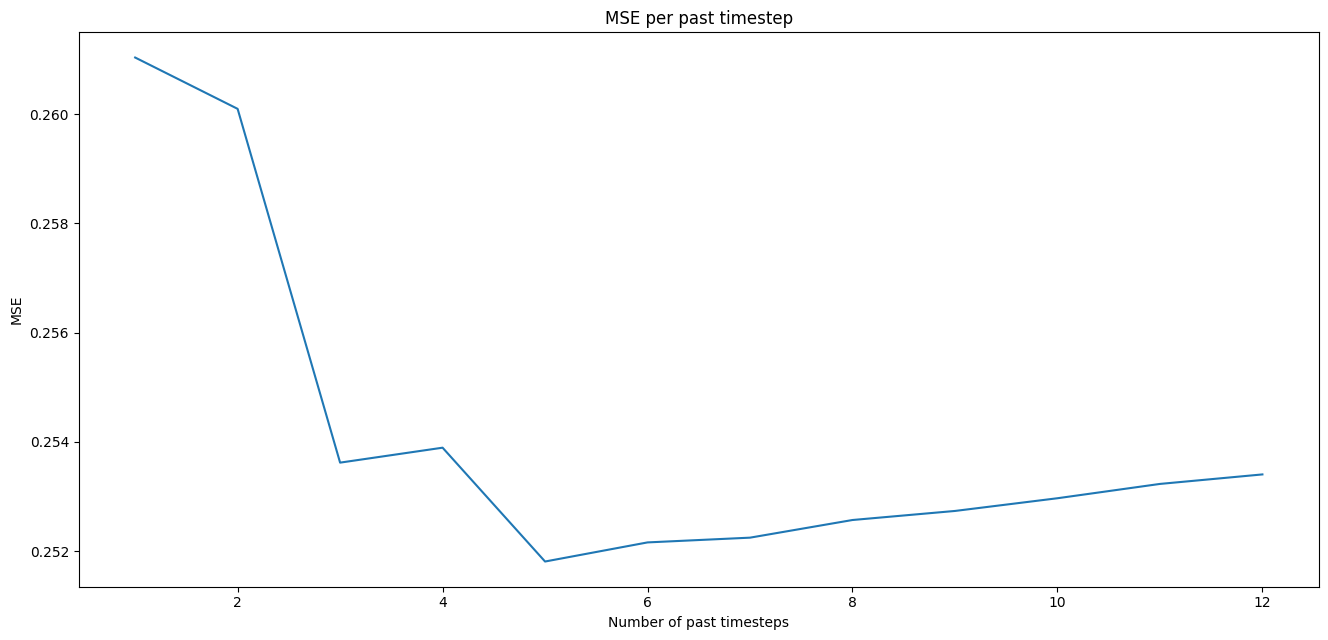

In [23]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mse_list)
plt.title('MSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MSE')
plt.show()

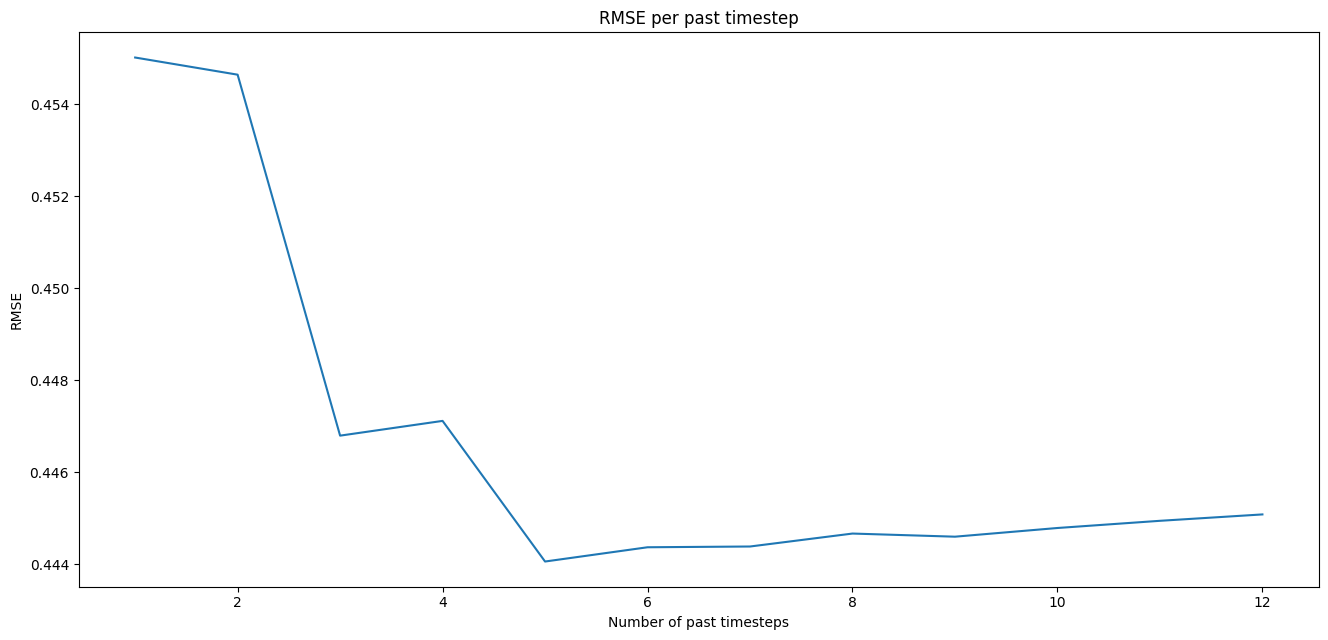

In [24]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), rmse_list)
plt.title('RMSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('RMSE')
plt.show()

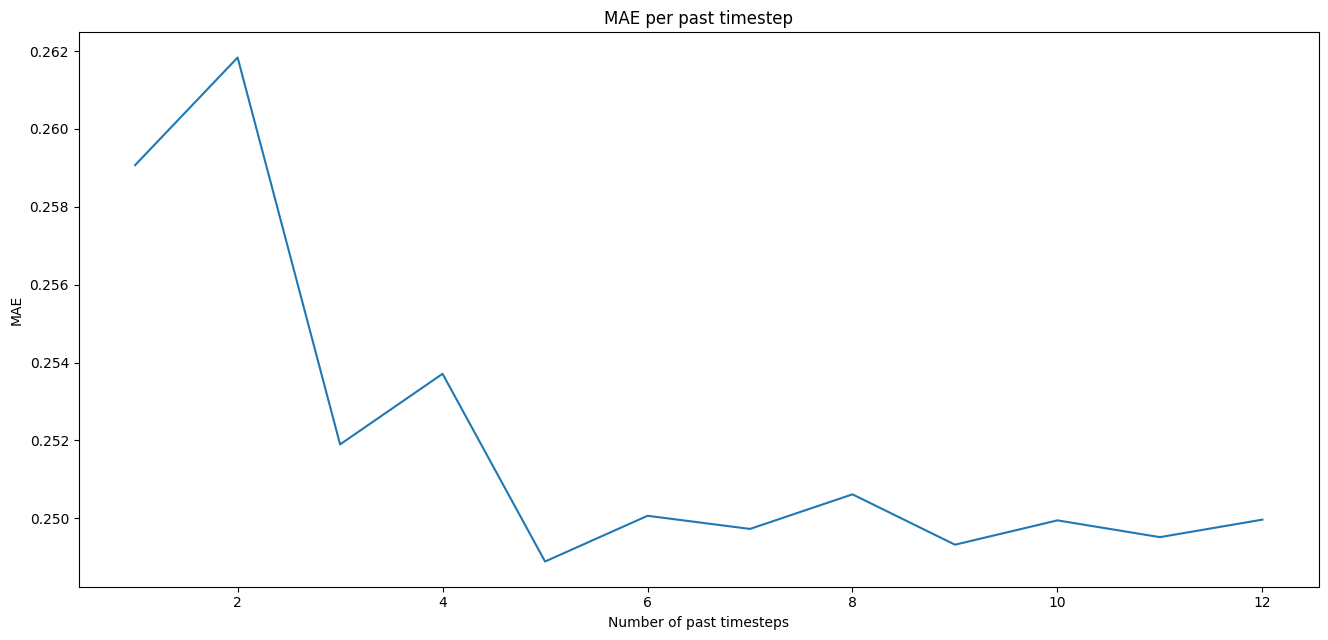

In [25]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mae_list)
plt.title('MAE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MAE')
plt.show()

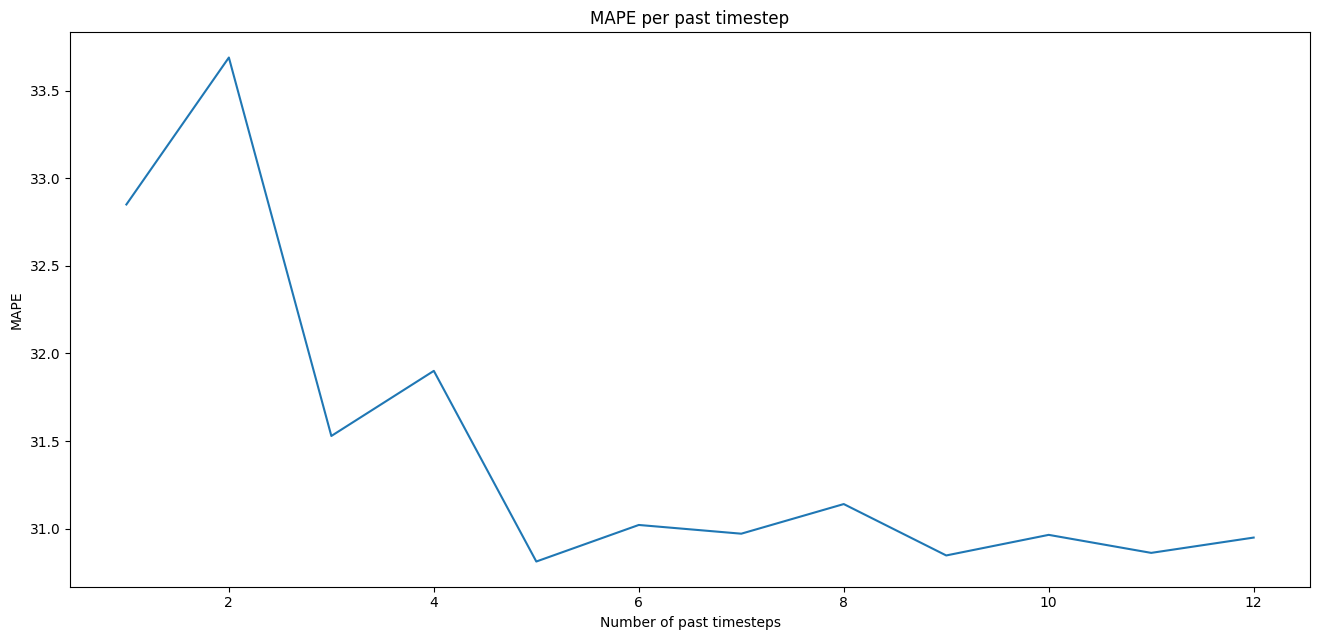

In [26]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mape_list)
plt.title('MAPE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MAPE')
plt.show()

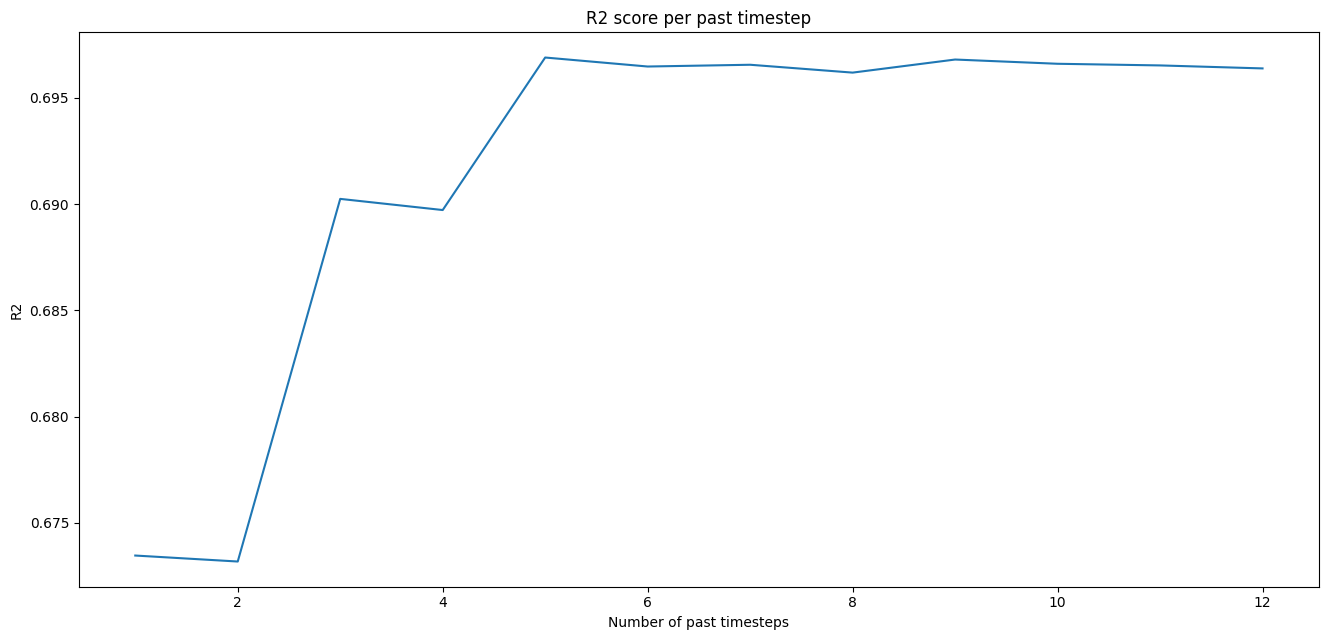

In [27]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), r2_list)
plt.title('R2 score per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('R2')
plt.show()

# Polynomial Regression

### Test for last 6 hours

In [30]:
degree_list = []
num_iters = [11,9,7]
for degree in range(2,5):
    p_global_list = []
    print("\n\t\tDegree ", degree)
    for i in range(1,num_iters[degree-2]):
        print("\nIteration ", i)
        X, y = last_energy_points(df, i)
        X_train, X_test, y_train, y_test = prepare_polynomial(X, y, deg=degree)
        print(X_train[0].shape, X_test[0].shape, len(y_train), len(y_test))
        p_model_list, p_preds_list, p_metrics_list = predict_show_results(X_train, X_test, y_train, y_test)
        print()
        total_averaged_metrics(p_metrics_list)
        p_global_list.append(p_metrics_list)

    degree_list.append(p_global_list)


		Degree  2

Iteration  1
(28108, 2) (7027, 2) 51 51

Total Averaged MSE: 0.197
Total Averaged RMSE: 0.4
Total Averaged MAE: 0.229
Total Averaged MAPE: 31.793
Total Averaged R2: 0.652

Iteration  2
(28107, 5) (7027, 5) 51 51

Total Averaged MSE: 0.19
Total Averaged RMSE: 0.393
Total Averaged MAE: 0.226
Total Averaged MAPE: 31.442
Total Averaged R2: 0.667

Iteration  3
(28106, 9) (7027, 9) 51 51

Total Averaged MSE: 0.186
Total Averaged RMSE: 0.386
Total Averaged MAE: 0.218
Total Averaged MAPE: 30.048
Total Averaged R2: 0.687

Iteration  4
(28105, 14) (7027, 14) 51 51

Total Averaged MSE: 0.197
Total Averaged RMSE: 0.394
Total Averaged MAE: 0.221
Total Averaged MAPE: 30.473
Total Averaged R2: 0.678

Iteration  5
(28104, 20) (7027, 20) 51 51

Total Averaged MSE: 0.182
Total Averaged RMSE: 0.382
Total Averaged MAE: 0.215
Total Averaged MAPE: 29.55
Total Averaged R2: 0.696

Iteration  6
(28104, 27) (7026, 27) 51 51

Total Averaged MSE: 0.188
Total Averaged RMSE: 0.389
Total Averaged MAE: 

In [32]:
p_mse_list = []
p_rmse_list = []
p_mae_list = []
p_mape_list = []
p_r2_list = []
for degree in range (0,3):
    tmp1, tmp2, tmp3, tmp4, tmp5 = [],[],[],[],[]
    for i in range(0,num_iters[degree]-1):
        tmp1.append(sum(i for i, j, k, l, m in degree_list[degree][i])/len(degree_list[degree][i]))
        tmp2.append(sum(j for i, j, k, l, m in degree_list[degree][i])/len(degree_list[degree][i]))
        tmp3.append(sum(k for i, j, k, l, m in degree_list[degree][i])/len(degree_list[degree][i]))
        tmp4.append(sum(l for i, j, k, l, m in degree_list[degree][i])/len(degree_list[degree][i]) * 100)
        tmp5.append(sum(m for i, j, k, l, m in degree_list[degree][i])/len(degree_list[degree][i]))
    p_mse_list.append(tmp1)
    p_rmse_list.append(tmp2)
    p_mae_list.append(tmp3)
    p_mape_list.append(tmp4)
    p_r2_list.append(tmp5)

## Comparison between Linear and Polynomial

Text(0, 0.5, 'MSE')

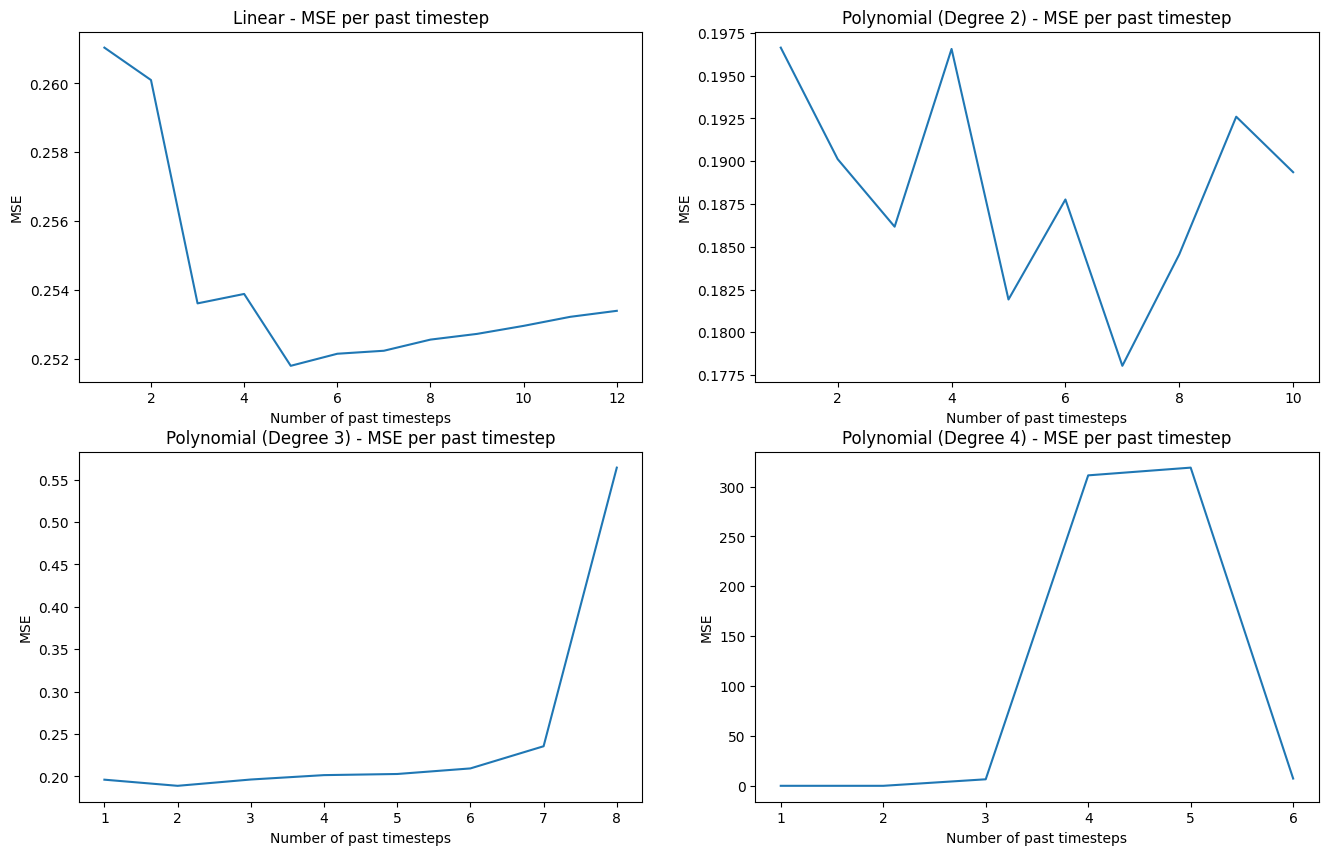

In [34]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mse_list)
axis[0,0].set_title("Linear - MSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MSE")
  
axis[0,1].plot(range(1,11), p_mse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MSE")

axis[1,0].plot(range(1,9), p_mse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MSE")

axis[1,1].plot(range(1,7), p_mse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MSE")

Text(0, 0.5, 'RMSE')

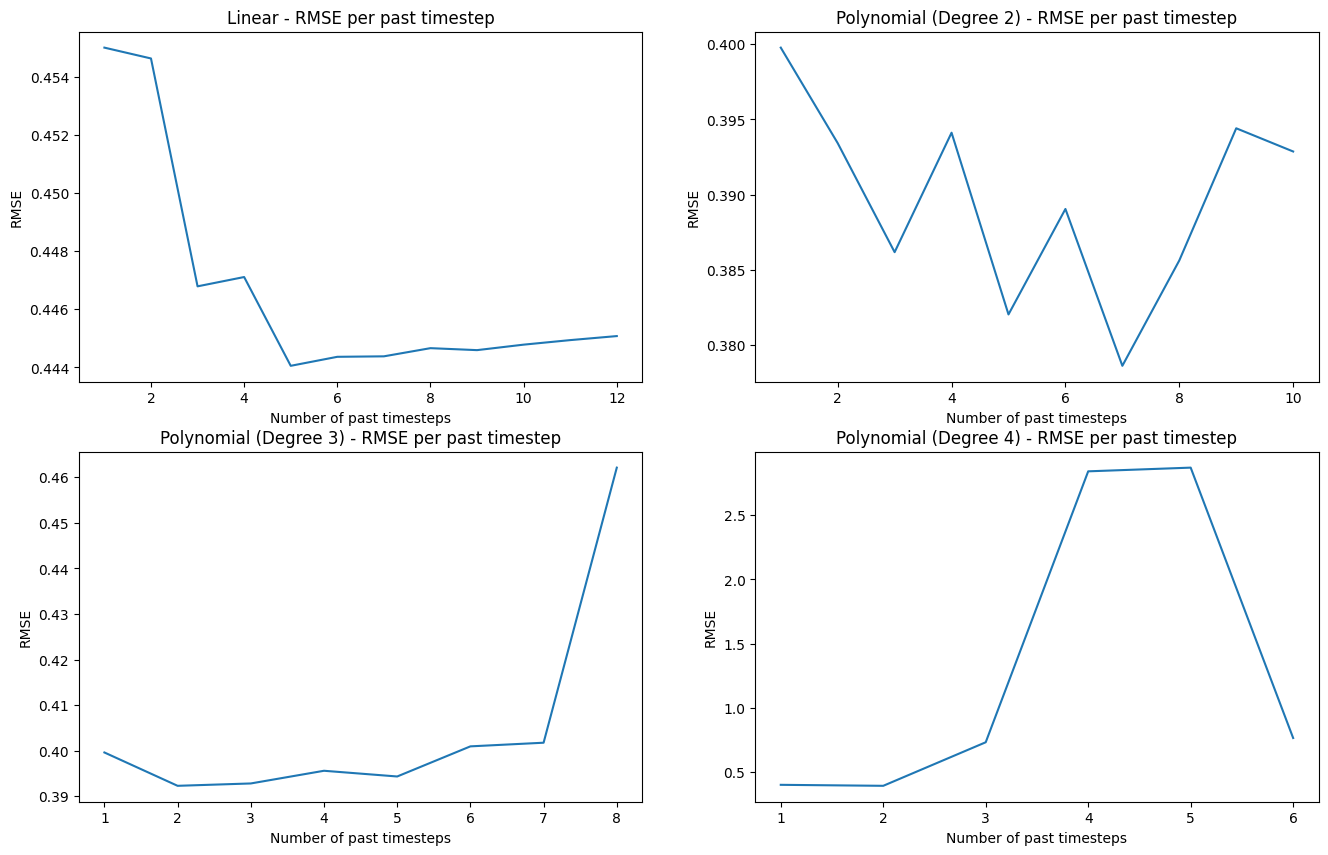

In [35]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), rmse_list)
axis[0,0].set_title("Linear - RMSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("RMSE")
  
axis[0,1].plot(range(1,11), p_rmse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - RMSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("RMSE")

axis[1,0].plot(range(1,9), p_rmse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - RMSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("RMSE")

axis[1,1].plot(range(1,7), p_rmse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - RMSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("RMSE")

Text(0, 0.5, 'MAE')

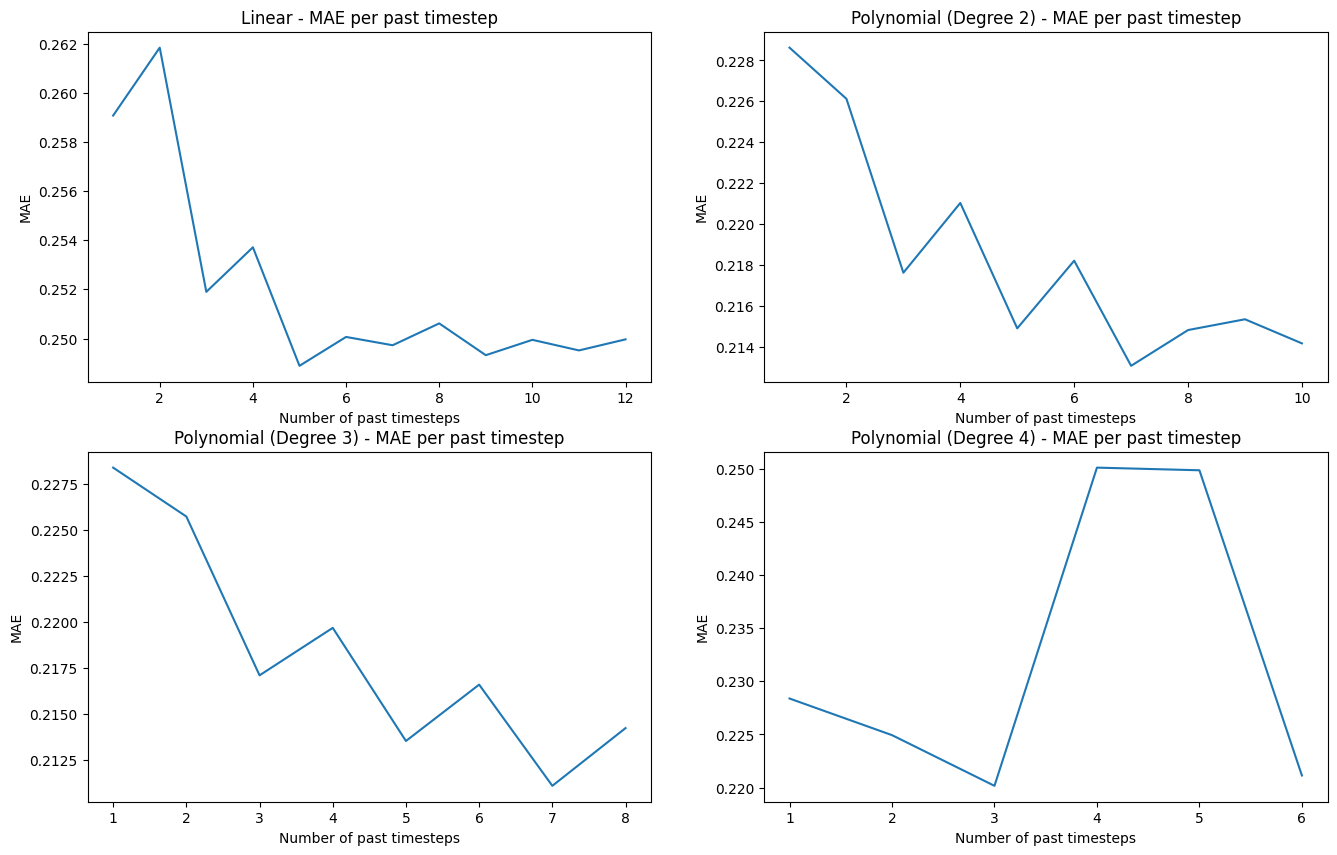

In [36]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mae_list)
axis[0,0].set_title("Linear - MAE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MAE")
  
axis[0,1].plot(range(1,11), p_mae_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MAE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MAE")

axis[1,0].plot(range(1,9), p_mae_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MAE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MAE")

axis[1,1].plot(range(1,7), p_mae_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MAE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MAE")

Text(0, 0.5, 'MAPE')

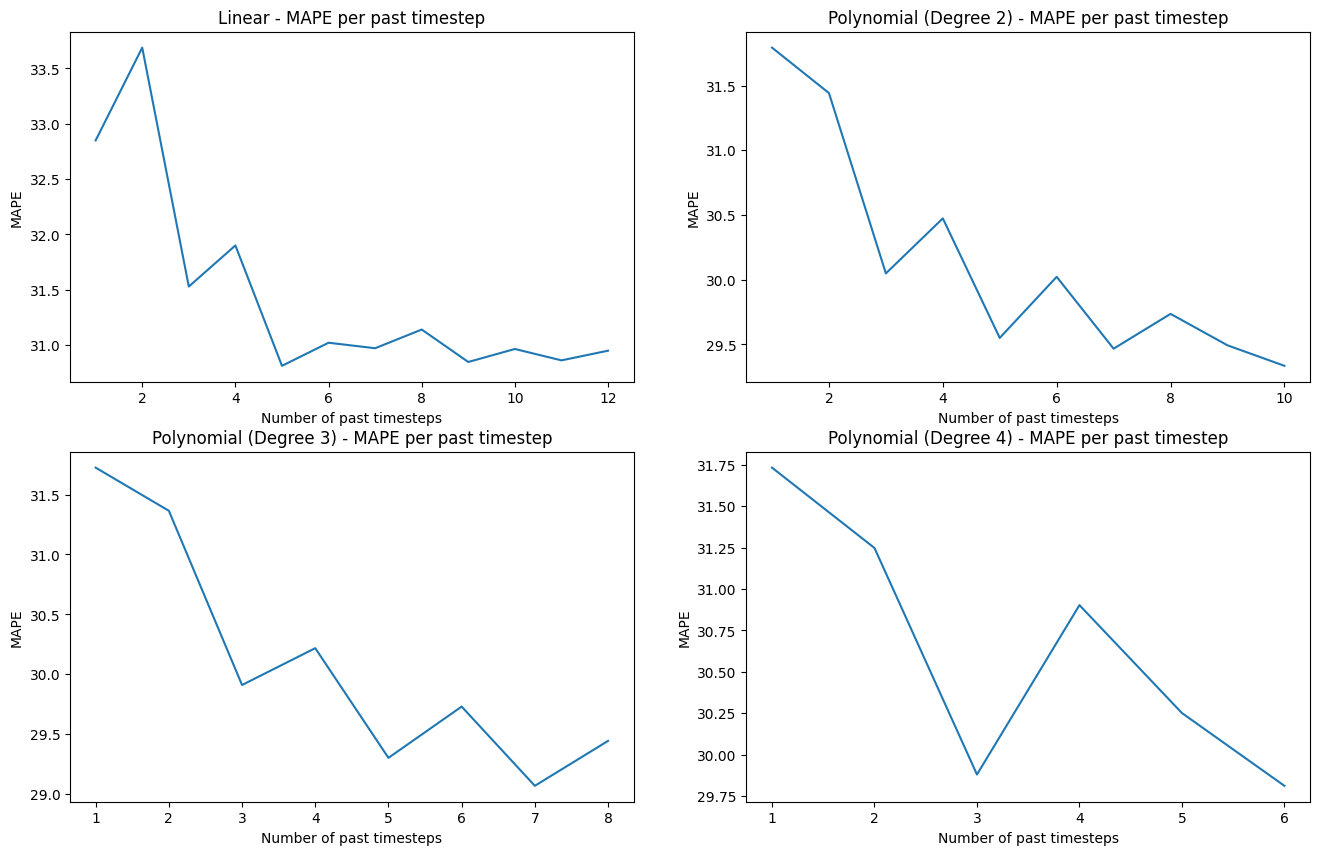

In [37]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mape_list)
axis[0,0].set_title("Linear - MAPE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MAPE")
  
axis[0,1].plot(range(1,11), p_mape_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MAPE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MAPE")

axis[1,0].plot(range(1,9), p_mape_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MAPE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MAPE")

axis[1,1].plot(range(1,7), p_mape_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MAPE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MAPE")

Text(0, 0.5, 'R2 score')

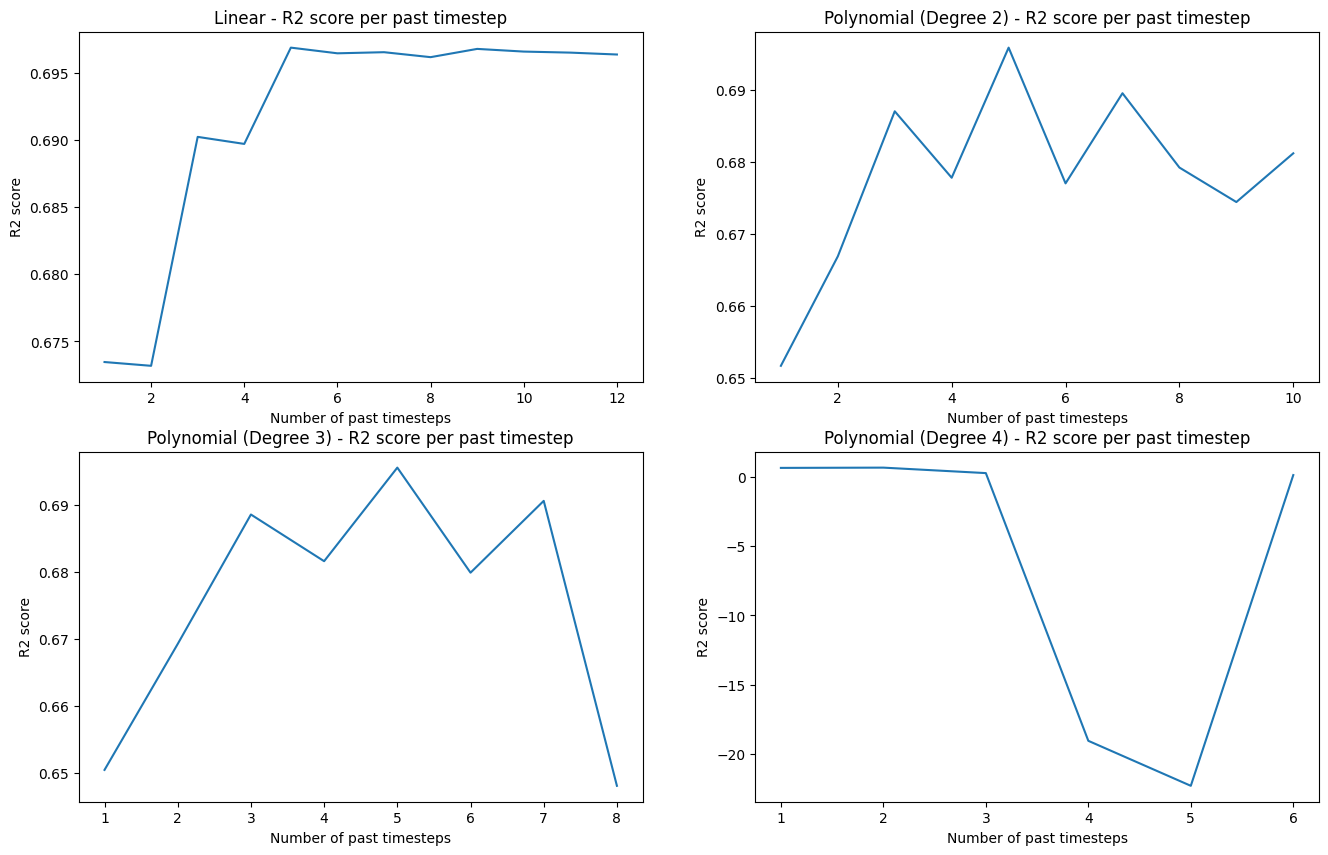

In [38]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), r2_list)
axis[0,0].set_title("Linear - R2 score per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("R2 score")
  
axis[0,1].plot(range(1,11), p_r2_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - R2 score per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("R2 score")

axis[1,0].plot(range(1,9), p_r2_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - R2 score per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("R2 score")

axis[1,1].plot(range(1,7), p_r2_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - R2 score per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("R2 score")

### Last energy point

### Last 2 energy points

### Last 3 energy points

### Last 4 energy points